In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class bandit(object):
    def __init__(self, T, K):
        self.K = K
        self.T = T
        self.mu = np.random.normal(0,1, self.K)
        self.opt_arm = np.argmax(self.mu)
        
        self.rewards = np.zeros(shape=(self.T, self.K))
        for t in range(self.T):
            self.rewards[t] = np.random.normal(self.mu, 1, self.K)
        
        self.opt_rewards = self.mu[self.opt_arm]*np.ones(self.T)
        
    def get_realization(self, arms):
        mu_i = np.zeros(self.T)
        for t in range(self.T):
            mu_i[t] = self.mu[arms[t]]
        return mu_i
    
    def get_reward(self, arm, t):
        return self.rewards[t][arm]
        

In [3]:
class algorithm(object):
    def __init__(self, T, K):
        self.K = K
        self.T = T
        self.rewards = np.zeros(self.T)
        self.Q = np.zeros(self.K)
        self.Q_sum = np.zeros(shape=(self.T+1, self.K))
        self.arm_cnt = np.zeros(self.K).astype(int)
        self.arm_chosen = np.zeros(self.T).astype(int)
    
    def update_Q(self, reward, arm, t):
        self.rewards[t] = reward
        self.Q_sum[t][arm] = reward
        self.arm_cnt[arm] += 1
        self.Q[arm] = self.Q_sum[:,arm].sum()/self.arm_cnt[arm]

In [76]:
T = 1000
K = 10
times = 100

In [77]:
class greedy(algorithm):
    def __init__(self, T, K, p):
        super().__init__(T, K)
        self.N = p
        self.cur_arm = [0, self.N]
        
    def pull(self, t):
        if self.cur_arm[0] < self.K-1:
            self.cur_arm[1] -= 1
            a = self.cur_arm[0]
            if self.cur_arm[1] <= 0:
                self.cur_arm[1] = self.N
                self.cur_arm[0] += 1
            return a
        else:
            return np.argmax(self.Q)


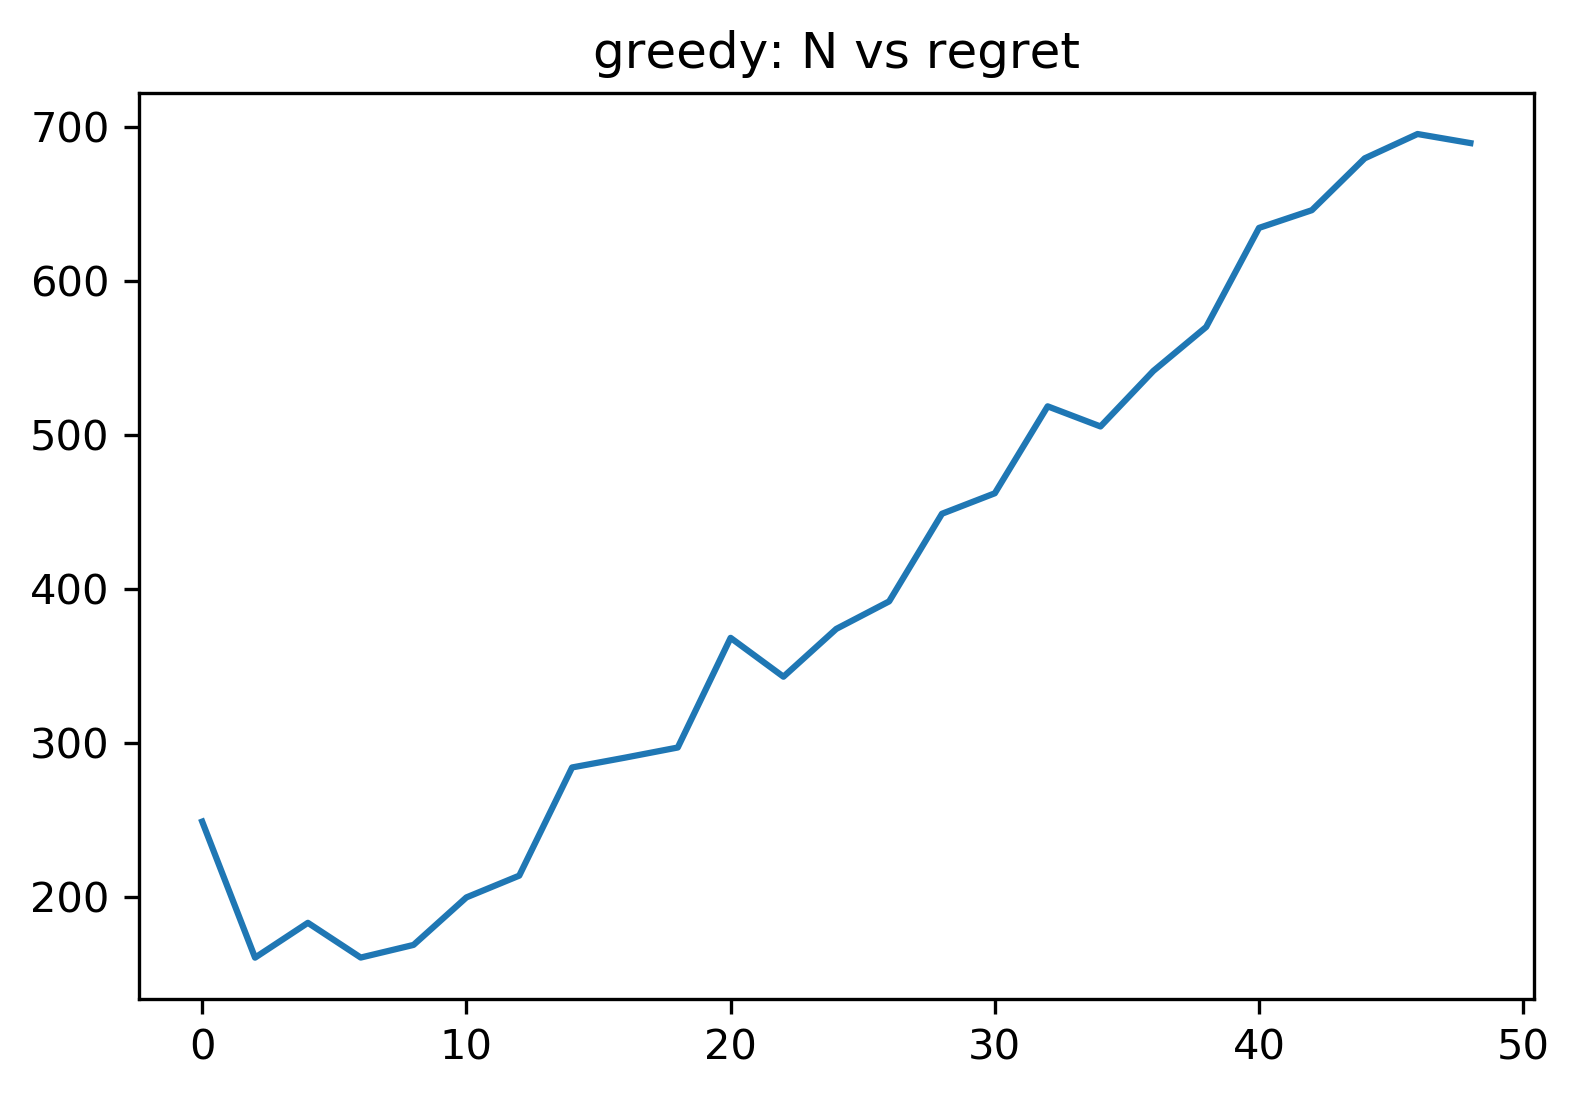

In [81]:
p_list = np.arange(0,50,2)
res = np.zeros(len(p_list))
for pi,p in enumerate(p_list):
    r_sum = 0
    for _ in range(times):
        b = bandit(T=T, K=K)
        g = greedy(T=T, K=K, p=p)

        g_rewards = np.zeros(T)
        for t in range(T):
            a = g.pull(t)
            r = b.get_reward(a, t)
            g.update_Q(r, a, t)
            g_rewards[t] = b.mu[a]

        r_sum += (b.opt_rewards-g_rewards).cumsum()[-1]
    res[pi] = r_sum/times

fig, ax = plt.subplots(dpi=300)
ax.plot(p_list, res)
ax.set_title('greedy: N vs regret')
plt.show()

In [51]:
class e_greedy(algorithm):
    def __init__(self, T, K, p):
        super().__init__(T, K)
        self.e = p
        
    def pull(self, t):
        if np.random.uniform(0.,1., 1) > self.e:
            return np.argmax(self.Q)
        else:
            return np.random.randint(0, self.K)

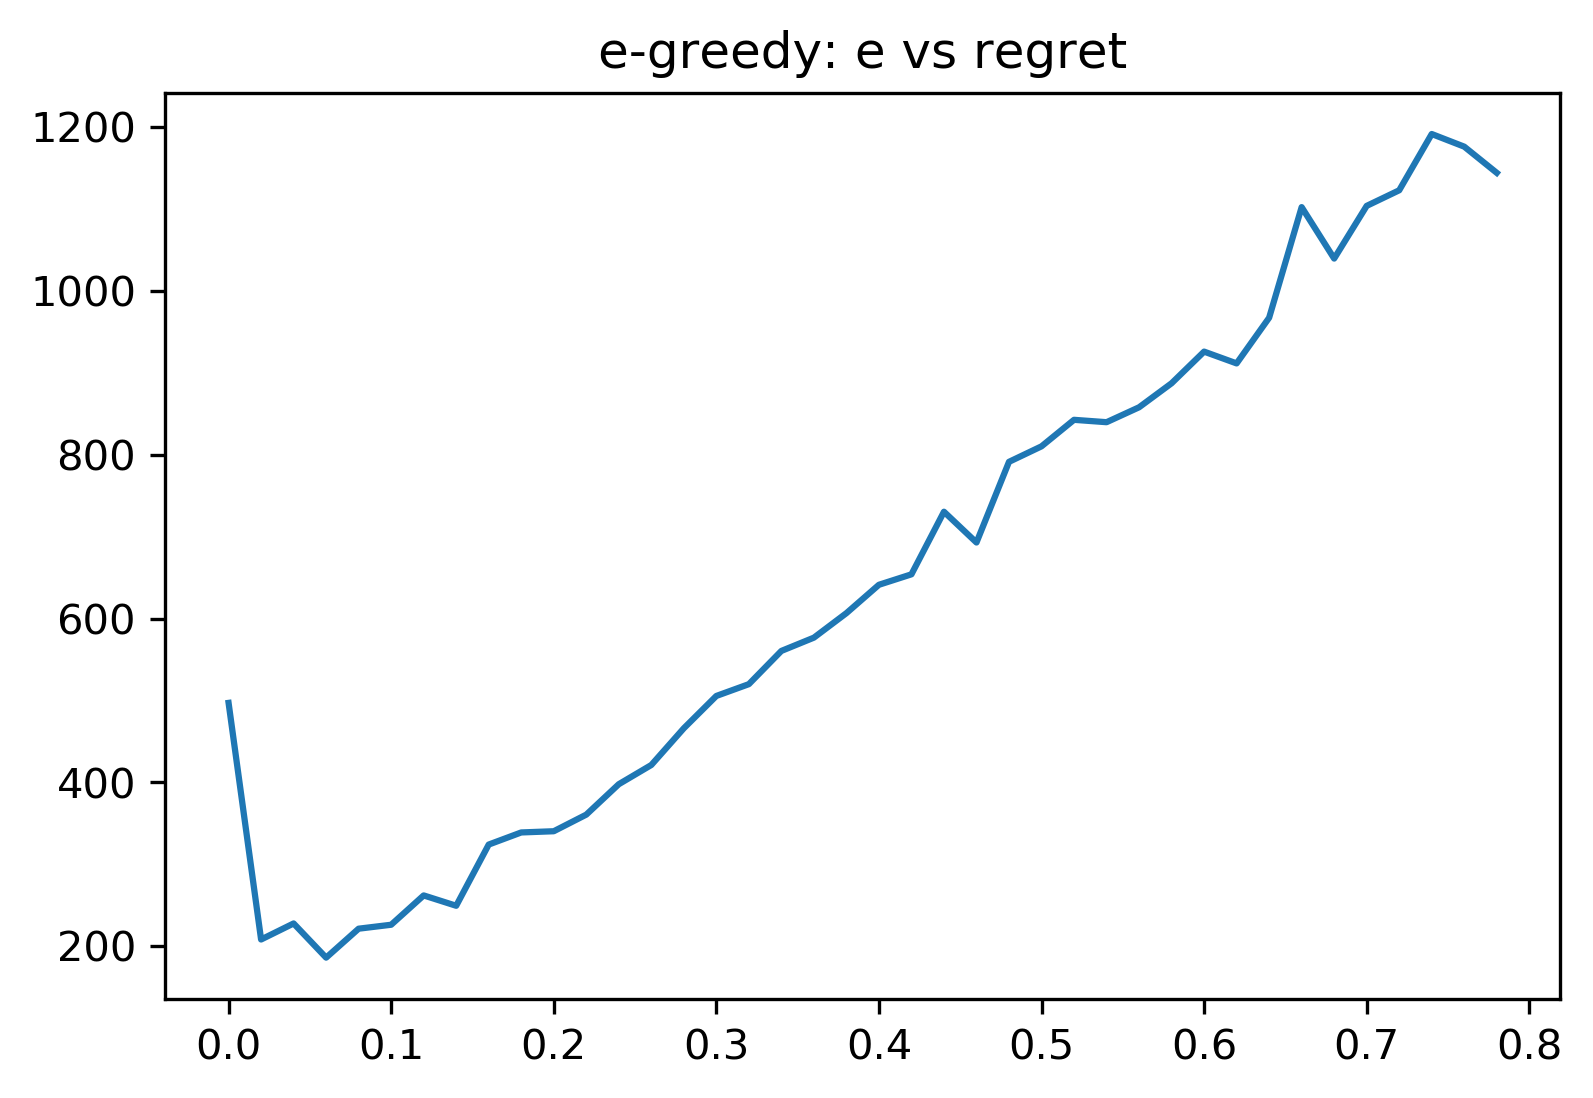

In [82]:
p_list = np.arange(0,0.8,0.02)
res = np.zeros(len(p_list))
for pi,p in enumerate(p_list):
    r_sum = 0
    for _ in range(times):
        b = bandit(T=T, K=K)
        g = e_greedy(T=T, K=K, p=p)

        g_rewards = np.zeros(T)
        for t in range(T):
            a = g.pull(t)
            r = b.get_reward(a, t)
            g.update_Q(r, a, t)
            g_rewards[t] = b.mu[a]

        r_sum += (b.opt_rewards-g_rewards).cumsum()[-1]
    res[pi] = r_sum/times

fig, ax = plt.subplots(dpi=300)
ax.plot(p_list, res)
ax.set_title('e-greedy: e vs regret')
plt.show()

In [65]:
class UCB(algorithm):
    def __init__(self, T, K, p):
        super().__init__(T, K)
        self.c = p
        
    def pull(self, t):
        return np.argmax(self.Q + self.c*np.sqrt( np.log(t)/(self.arm_cnt+0.01) ))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


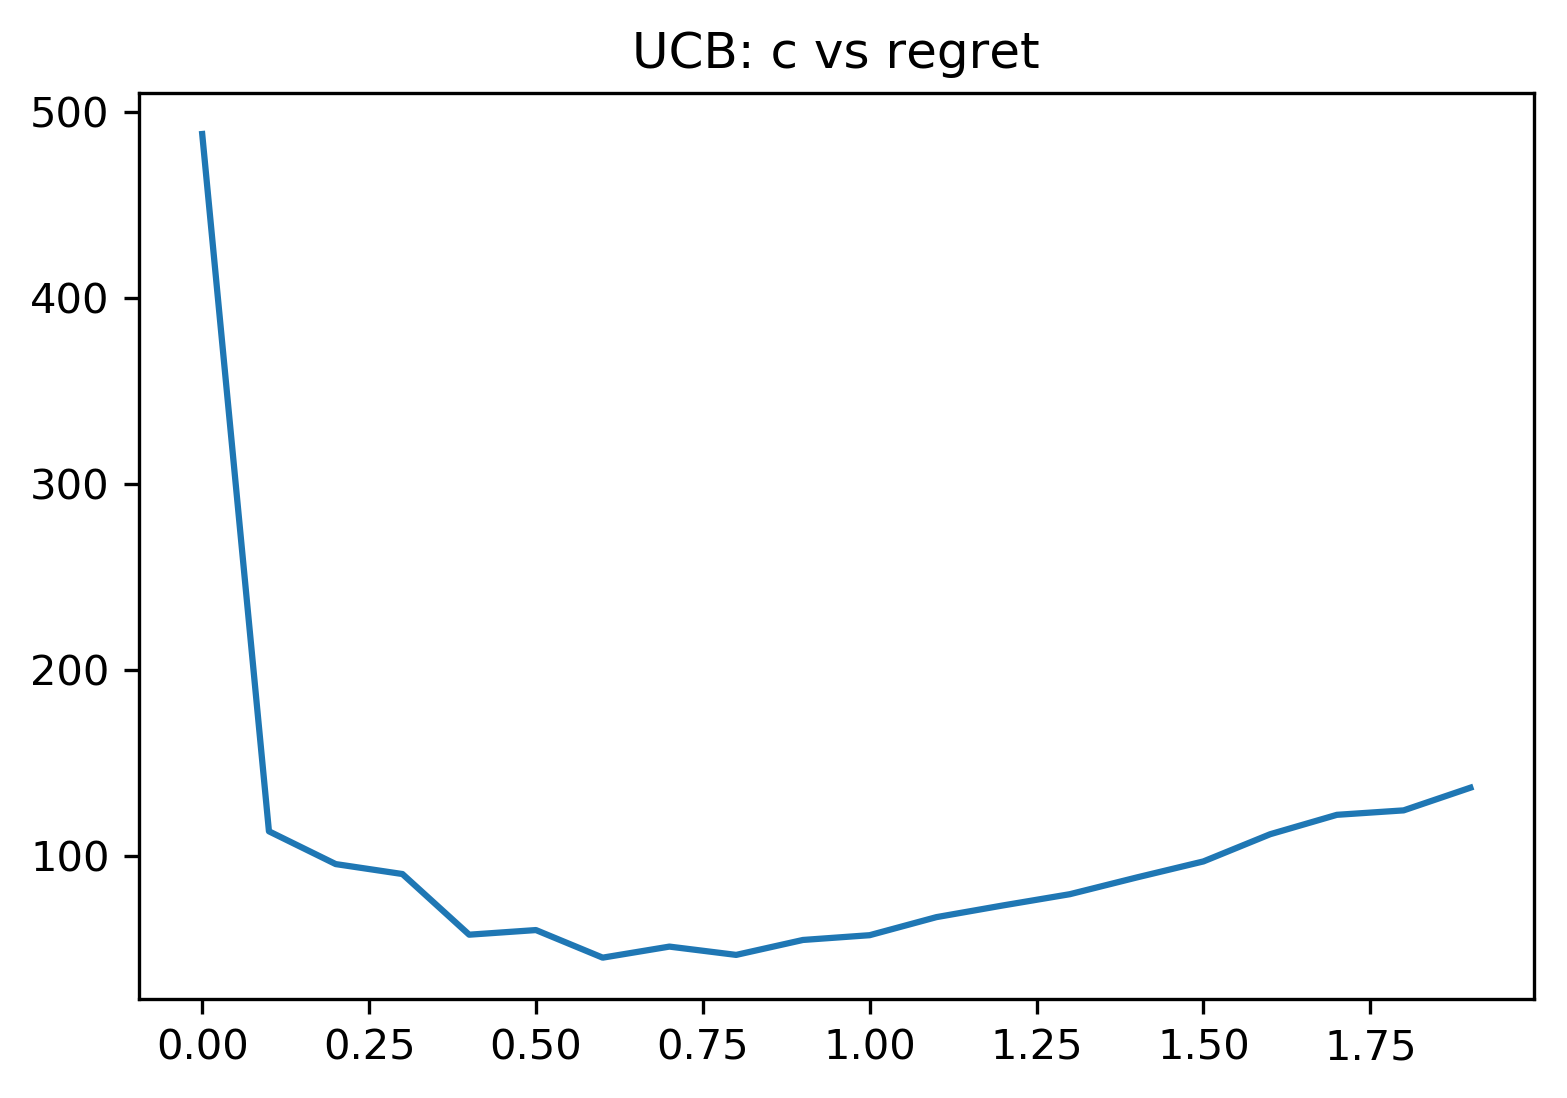

In [66]:
p_list = np.arange(0,2,0.1)
res = np.zeros(len(p_list))
for pi,p in enumerate(p_list):
    r_sum = 0
    for _ in range(times):
        b = bandit(T=T, K=K)
        g = UCB(T=T, K=K, p=p)

        g_rewards = np.zeros(T)
        for t in range(T):
            a = g.pull(t)
            r = b.get_reward(a, t)
            g.update_Q(r, a, t)
            g_rewards[t] = b.mu[a]

        r_sum += (b.opt_rewards-g_rewards).cumsum()[-1]
    res[pi] = r_sum/times

fig, ax = plt.subplots(dpi=300)
ax.plot(p_list, res)
ax.set_title('UCB: c vs regret')
plt.show()

In [73]:
class Gradient(algorithm):
    def __init__(self, T, K, p):
        super().__init__(T, K)
        self.a = p
        self.r_sum = 0

    def update_Q(self, reward, arm, t):
        self.r_sum += reward 
        Q_buf = self.Q[arm]
        self.Q = self.Q - self.a*(reward - self.r_sum/(t+1))*self.soft_max(t)
        self.Q[arm] = Q_buf + self.a*(reward - self.r_sum/(t+1))*(1-self.soft_max(t)[arm])
        self.rewards[t] = reward

    def soft_max(self, t):
        return np.exp(self.Q+0.01)/np.sum(np.exp(self.Q+0.01))

    def pull(self, t):
        s = self.soft_max(t)
        if not np.isfinite(s).all():
            print(self.Q[t], s)
        return np.random.choice(self.K, 1, p=self.soft_max(t))[0]

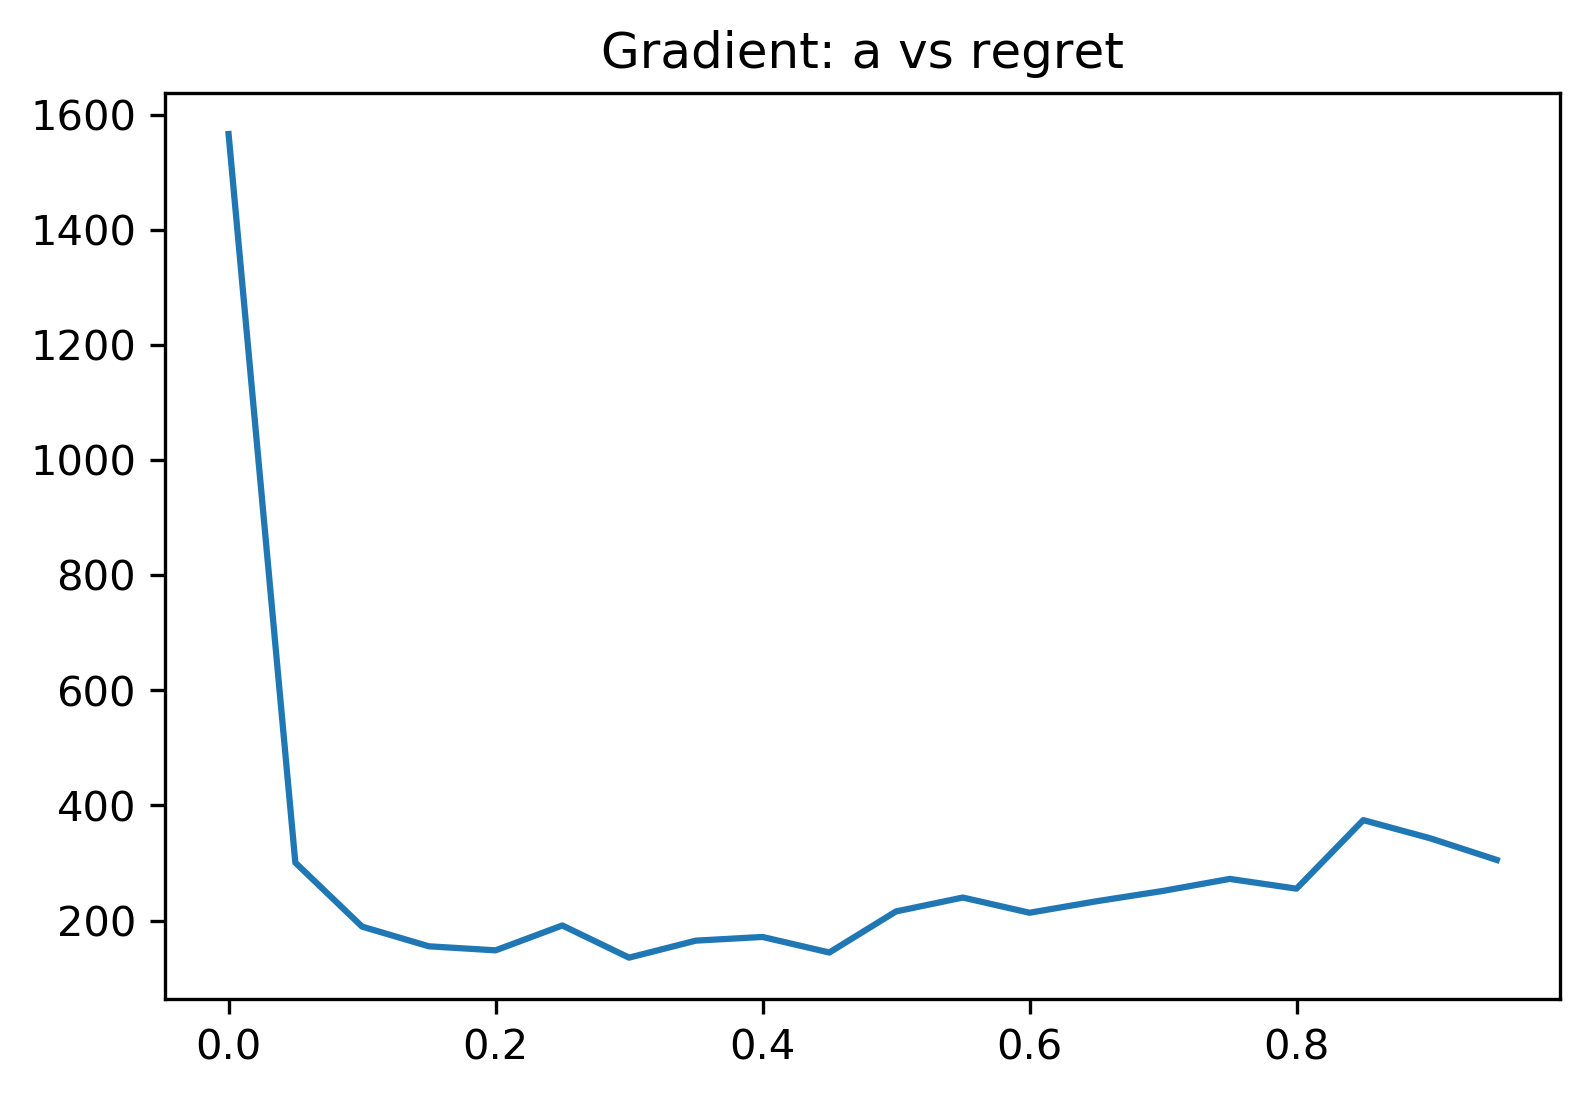

In [75]:
p_list = np.arange(0,1,0.05)
res = np.zeros(len(p_list))
for pi,p in enumerate(p_list):
    r_sum = 0
    for _ in range(times):
        b = bandit(T=T, K=K)
        g = Gradient(T=T, K=K, p=p)

        g_rewards = np.zeros(T)
        for t in range(T):
            a = g.pull(t)
            r = b.get_reward(a, t)
            g.update_Q(r, a, t)
            g_rewards[t] = b.mu[a]

        r_sum += (b.opt_rewards-g_rewards).cumsum()[-1]
    res[pi] = r_sum/times

fig, ax = plt.subplots(dpi=300)
ax.plot(p_list, res)
ax.set_title('Gradient: a vs regret')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


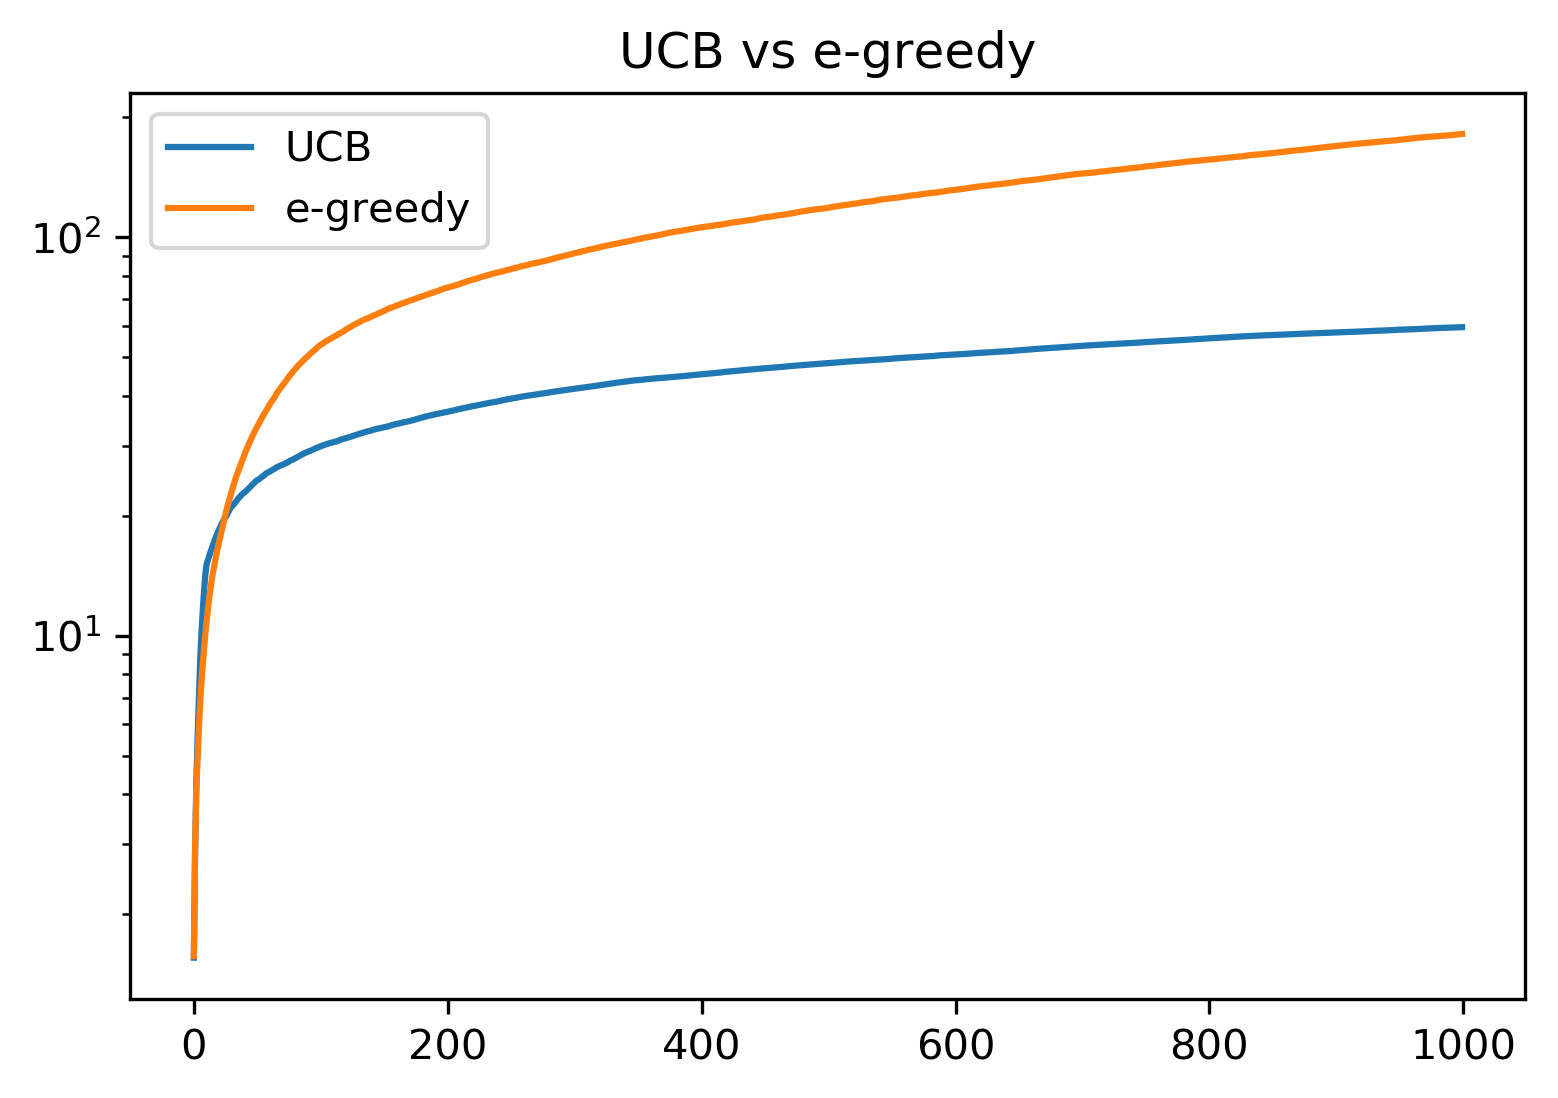

In [102]:
ucb_r_sum = np.zeros(T)
eg_r_sum = np.zeros(T)
np.random.seed(0)

for _ in range(times):
    b = bandit(T=T, K=K)
    ucb = UCB(T=T, K=K, p=0.7)
    eg = e_greedy(T=T, K=K, p=0.07)

    ucb_rewards = np.zeros(T)
    eg_rewards = np.zeros(T)
    for t in range(T):
        a = ucb.pull(t)
        r = b.get_reward(a, t)
        ucb.update_Q(r, a, t)
        ucb_rewards[t] = b.mu[a]
        
        a = eg.pull(t)
        r = b.get_reward(a, t)
        eg.update_Q(r, a, t)
        eg_rewards[t] = b.mu[a]

    ucb_r_sum += (b.opt_rewards-ucb_rewards).cumsum()
    eg_r_sum += (b.opt_rewards-eg_rewards).cumsum()
    
    
fig, ax = plt.subplots(dpi=300)
ax.plot(np.arange(T), ucb_r_sum/times, label='UCB')
ax.plot(np.arange(T), eg_r_sum/times, label='e-greedy')
ax.set_yscale('log')
ax.set_title('UCB vs e-greedy')
ax.legend()
plt.show()